/Users/wilmer/miniconda3/envs/wiseis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wilmer/miniconda3/envs/wiseis/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Saved sorted data to: ./CAP_6Outlier_3SAC/sac_data_snr_filtered.csv


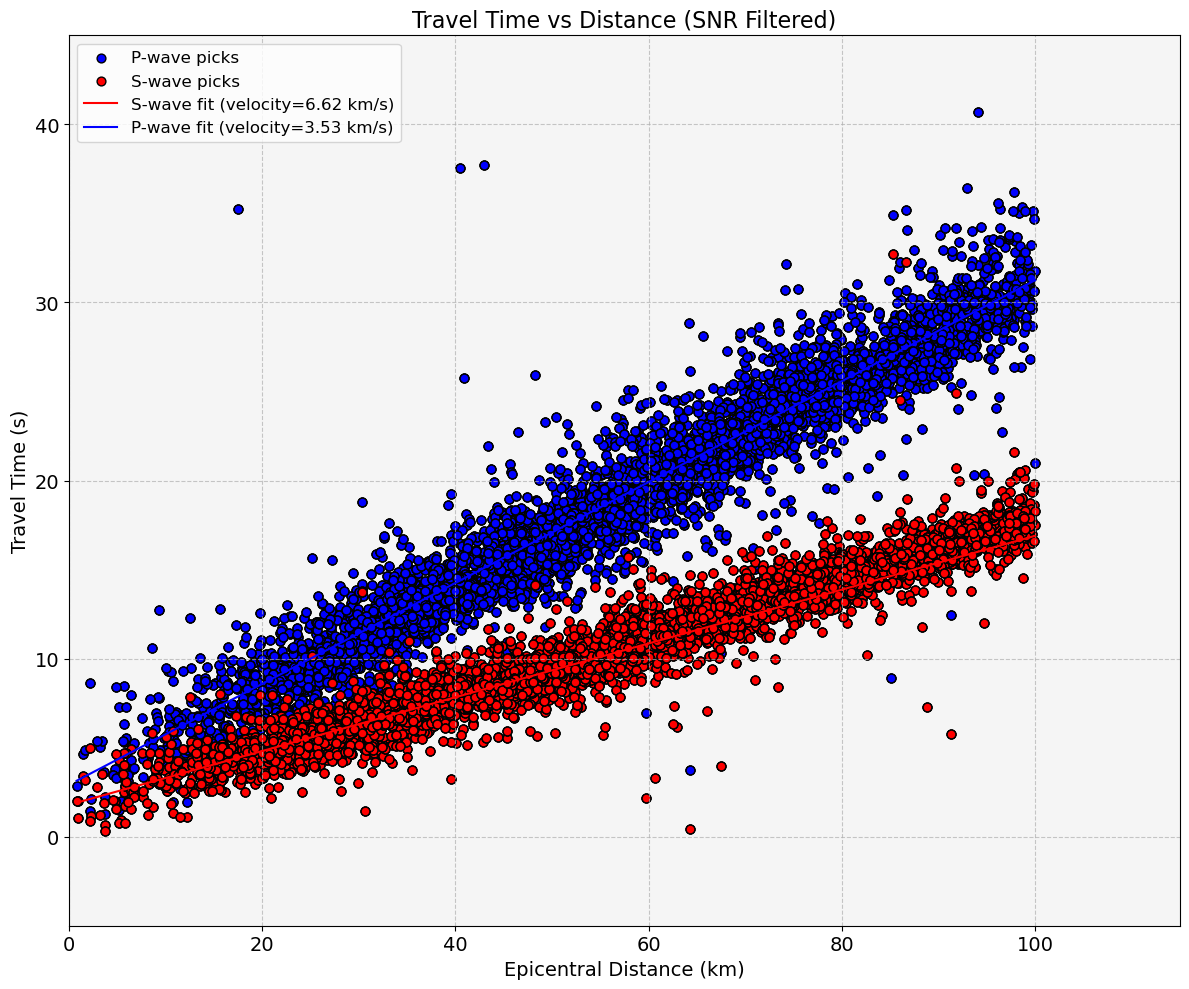

Velocity for S-wave: 6.62 km/s
Velocity for P-wave: 3.53 km/s
Vp/Vs ratio: 0.53
Copied SAC file: YB.AT06.2013-05-20T11:25.BHE.SAC
Copied SAC file: YB.AT06.2013-05-20T11:25.BHN.SAC
Copied SAC file: YB.AT06.2013-05-20T11:25.BHZ.SAC
Copied SAC file: YB.AT06.2013-05-23T05:21.BHE.SAC
Copied SAC file: YB.AT06.2013-05-23T05:21.BHN.SAC
Copied SAC file: YB.AT06.2013-05-23T05:21.BHZ.SAC
Copied SAC file: YB.AT06.2013-05-25T11:15.BHE.SAC
Copied SAC file: YB.AT06.2013-05-25T11:15.BHN.SAC
Copied SAC file: YB.AT06.2013-05-25T11:15.BHZ.SAC
Copied SAC file: YB.AT06.2013-05-27T14:44.BHE.SAC
Copied SAC file: YB.AT06.2013-05-27T14:44.BHN.SAC
Copied SAC file: YB.AT06.2013-05-27T14:44.BHZ.SAC
Copied SAC file: YB.AT06.2013-06-11T15:07.BHE.SAC
Copied SAC file: YB.AT06.2013-06-11T15:07.BHN.SAC
Copied SAC file: YB.AT06.2013-06-11T15:07.BHZ.SAC
Copied SAC file: YB.AT06.2013-06-21T09:07.BHE.SAC
Copied SAC file: YB.AT06.2013-06-21T09:07.BHN.SAC
Copied SAC file: YB.AT06.2013-06-21T09:07.BHZ.SAC
Copied SAC file: YB.

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from scipy import stats
import shutil

def get_sac_header_values(sac_file_path):
    try:
        st = read(sac_file_path)
        tr = st[0]
        o_value = tr.stats.sac.o
        t1_value = tr.stats.sac.t1
        t2_value = tr.stats.sac.t2
        dist_value = tr.stats.sac.dist
        return o_value, t1_value, t2_value, dist_value, tr
    except Exception as e:
        print(f"Error processing file {sac_file_path}: {e}")
        return None, None, None, None, None

def calculate_snr(tr, o_value, t2_value):
    data = tr.data
    sampling_rate = tr.stats.sampling_rate

    noise_start = int((o_value - 5) * sampling_rate)
    noise_end = int(o_value * sampling_rate)
    s_wave_start = int(t2_value * sampling_rate)
    s_wave_end = int((t2_value + 5) * sampling_rate)
    coda_start = int((t2_value + 0.5 * (t2_value - o_value)) * sampling_rate)
    coda_end = min(int((t2_value + 0.5 *  (t2_value - o_value) + 15) * sampling_rate), len(data))

    noise_window = data[max(0, noise_start):noise_end]
    s_wave_window = data[s_wave_start:s_wave_end]
    coda_window = data[coda_start:coda_end]

    noise_rms = np.sqrt(np.mean(np.square(noise_window)))
    s_wave_rms = np.sqrt(np.mean(np.square(s_wave_window)))
    coda_rms = np.sqrt(np.mean(np.square(coda_window)))

    s_snr = s_wave_rms / noise_rms if noise_rms != 0 else 0
    coda_snr = coda_rms / noise_rms if noise_rms != 0 else 0

    return s_snr, coda_snr

def process_sac_directory(directory_path, csv_file_path):
    data = []
    event_station_data = {}

    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist.")
        return

    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith(".SAC"):
                file_parts = entry.name.split('.')
                event_station = '.'.join(file_parts[:-2])  # YB.AT06.2013-05-23T05:21
                component = file_parts[-2]  # BHE, BHN, or BHZ

                sac_file_path = entry.path
                o_value, t1_value, t2_value, dist_value, tr = get_sac_header_values(sac_file_path)
                
                if None not in (o_value, t1_value, t2_value, dist_value, tr):
                    s_snr, coda_snr = calculate_snr(tr, o_value, t2_value)
                    
                    if event_station not in event_station_data:
                        event_station_data[event_station] = {
                            'components': {},
                            'dist': dist_value,
                            't1_minus_o': t1_value - o_value,
                            't2_minus_o': t2_value - o_value,
                            'max_s_snr': 0,
                            'max_coda_snr': 0
                        }
                    
                    event_station_data[event_station]['components'][component] = {
                        's_snr': s_snr,
                        'coda_snr': coda_snr
                    }
                    event_station_data[event_station]['max_s_snr'] = max(event_station_data[event_station]['max_s_snr'], s_snr)
                    event_station_data[event_station]['max_coda_snr'] = max(event_station_data[event_station]['max_coda_snr'], coda_snr)

    for event_station, info in event_station_data.items():
        if info['max_s_snr'] >= 3 and info['max_coda_snr'] >= 3:
            for component, snr_info in info['components'].items():
                data.append({
                    "Filename": f"{event_station}.{component}.SAC",
                    "Distance": info['dist'],
                    "t1_minus_O": info['t1_minus_o'],
                    "t2_minus_O": info['t2_minus_o'],
                    "S_SNR": snr_info['s_snr'],
                    "Coda_SNR": snr_info['coda_snr']
                })

    df = pd.DataFrame(data)
    df_sorted = df.sort_values(by='Filename')
    df_sorted.to_csv(csv_file_path, index=False)

    print(f"Saved sorted data to: {csv_file_path}")

    return df_sorted

def plot_data(df):
    plt.figure(figsize=(12, 10))

    plt.scatter(df['Distance'], df['t2_minus_O'], color="blue", label="P-wave picks", marker="o", s=40, edgecolor="black")
    plt.scatter(df['Distance'], df['t1_minus_O'], color="red", label="S-wave picks", marker="o", s=40, edgecolor="black")

    slope_p, intercept_p, _, _, _ = stats.linregress(df['Distance'], df['t2_minus_O'])
    slope_s, intercept_s, _, _, _ = stats.linregress(df['Distance'], df['t1_minus_O'])

    x = np.array([min(df['Distance']), max(df['Distance'])])
    plt.plot(x, slope_s * x + intercept_s, "r-", label=f"S-wave fit (velocity={1/slope_s:.2f} km/s)")
    plt.plot(x, slope_p * x + intercept_p, "b-", label=f"P-wave fit (velocity={1/slope_p:.2f} km/s)")

    plt.xlabel("Epicentral Distance (km)", fontsize=14)
    plt.ylabel("Travel Time (s)", fontsize=14)
    plt.title("Travel Time vs Distance (SNR Filtered)", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper left')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(-5, 45)
    plt.xlim(5, 105)
    ax = plt.gca()
    ax.set_facecolor("whitesmoke")
    plt.gcf().set_facecolor("white")

    plt.tight_layout()
    plt.show()

    return 1/slope_s, 1/slope_p

def copy_filtered_files(df, source_sac_dir, dest_sac_dir):
    os.makedirs(dest_sac_dir, exist_ok=True)

    copied_files = set()

    for _, row in df.iterrows():
        file_name = row['Filename']

        if file_name in copied_files:
            continue

        sac_src = os.path.join(source_sac_dir, file_name)
        sac_dst = os.path.join(dest_sac_dir, file_name)
        if os.path.exists(sac_src):
            shutil.copy2(sac_src, sac_dst)
            print(f"Copied SAC file: {file_name}")
        else:
            print(f"SAC file not found: {file_name}")

        copied_files.add(file_name)

    print(f"Copied {len(copied_files)} filtered SAC files in total.")

if __name__ == "__main__":
    sac_directory_path = "./CAP_6Outlier_3SAC"
    csv_file_path = "./CAP_6Outlier_3SAC/sac_data_snr_filtered.csv"
    dest_sac_dir = "./CAP_7SNR_3SAC"

    df = process_sac_directory(sac_directory_path, csv_file_path)

    if df is not None and not df.empty:
        velocity_s, velocity_p = plot_data(df)
        print(f"Velocity for S-wave: {velocity_s:.2f} km/s")
        print(f"Velocity for P-wave: {velocity_p:.2f} km/s")
        print(f"Vp/Vs ratio: {velocity_p/velocity_s:.2f}")

        copy_filtered_files(df, sac_directory_path, dest_sac_dir)
    else:
        print("No data to plot. Please check if any SAC files were successfully processed.")


Directory ./CAP_F_SAC does not exist.
No data to plot. Please check if any SAC files were successfully processed.
